# Monet-Style Images Generation with GAN
### 1. Project Topic
The goal of this project is to generate monet-style images from regular photos. I will build a model for this task using GAN - Generative Adversarial Network.

GAN is a Neural Network architecture which has two main components: a generator and a discriminator. Both components are trained together - the generator tries to create styled images, and the discriminator tries to correctly distinguish between real and generated images. As the training progresses, the generator improves its ability to create styled images, while the discriminator becomes better at distinguishing.

For this project I will use a special type of GAN, the CycleGAN, which is particularly usefull for style-transfer tasks like this one. CycleGAN uses two generators and two discriminators to learn the mapping between two different image styles (in this case, regular photos and monet-style images). It uses the cycle-consistency loss to ensure that the generated images can be converted back to their original style, which is useful, as we don't have paired training data (Monet pictures do not have corresponding original).

### 2. Data
The data for this project consists of two sets of images: regular photos (photo_jpg folder) and monet-style images (monet_jpg folder). I will only use the jpeg images and will ignore the tfrec images, as those are same images just in different format. There are 300 monet paintings images and 7028 regular-photo images. All images in both folders are in jpg format, all of them are 256x256 pixels, and all of them are in RBG colors (3 channels). Therefore the dimension of a data sample is (256,256,3)

### 3. Exploratory Data Analysis 
An important step in image-data analysis is to get a visual impression of the data. I will visualize 5 random images from each set:

2025-06-01 02:06:04.096483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748743564.285042      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748743564.337470      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748743577.593614      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


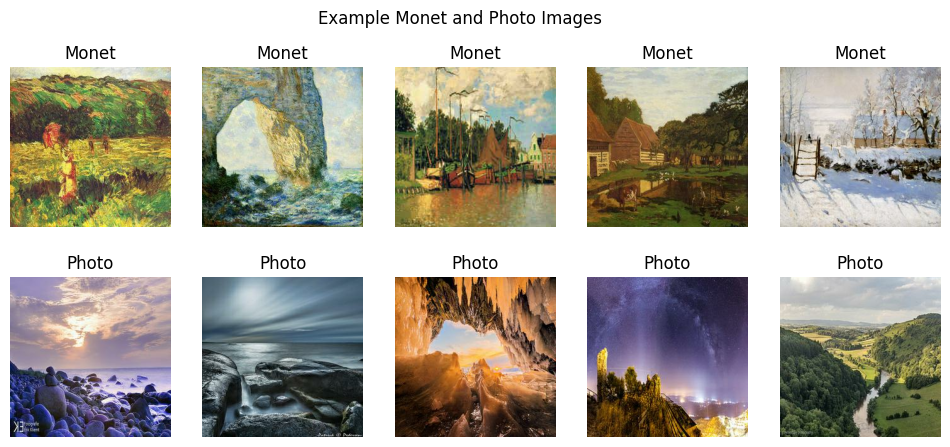

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

data_dir = "/kaggle/input/gan-getting-started"
monet_dir = os.path.join(data_dir, "monet_jpg")
photo_dir = os.path.join(data_dir, "photo_jpg")

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Visualize some samples
plt.figure(figsize=(12, 5))
for i, image_path in enumerate(tf.data.Dataset.list_files(os.path.join(monet_dir, "*.jpg")).take(5)):
    img = load_image(image_path.numpy().decode())
    plt.subplot(2, 5, i + 1)
    plt.imshow((img + 1) / 2.0)
    plt.title("Monet")
    plt.axis("off")
for i, image_path in enumerate(tf.data.Dataset.list_files(os.path.join(photo_dir, "*.jpg")).take(5)):
    img = load_image(image_path.numpy().decode())
    plt.subplot(2, 5, i + 6)
    plt.imshow((img + 1) / 2.0)
    plt.title("Photo")
    plt.axis("off")
plt.suptitle("Example Monet and Photo Images")
plt.show()



The Monet style is clearly distinguished in the upper row images, while bottom row shows realistic photos. My model will need to learn the monet style and apply it to regular photos.

The common problem with image data in general is the high number of features per sample. In my case the number of features is almost 200k:

In [2]:
image = load_image(tf.data.Dataset.list_files(os.path.join(monet_dir, "*.jpg")).take(1).as_numpy_iterator().__next__())
tf.reduce_prod(tf.shape(image))

<tf.Tensor: shape=(), dtype=int32, numpy=196608>

The high number of features per image can be problematic if all images are loaded at the same time. To solve that, I will use *tf.data.Dataset*, which will allow loading one image at a time. On the other hand, the number of monet images is small (300) and in order to have a better variety I will use data augmentation. In the next cell, I will implement both optimizations:

In [3]:
# Data augmentation
def augment_image(image):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness adjustment
    random = tf.random.uniform([], 0, 1)
    if random < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)
    return image

def load_dataset(image_folder):
    # Using a TensorFlow dataset to load images, to prevent memory issues
    image_paths = tf.data.Dataset.list_files(image_folder + "/*.jpg")
    image_paths.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return image_paths.map(lambda x: augment_image(load_image(x)), num_parallel_calls=tf.data.AUTOTUNE)

# Load datasets. I will use these datasets for training later.
monet_ds = load_dataset(monet_dir).repeat().shuffle(300).take(300).batch(1)
photo_ds = load_dataset(photo_dir).shuffle(10000).take(300).batch(1)

Another interesting observation is that monet-style pictures have a different distribution of colors. This will be helpful, as color transformation is relatively easy to learn. But, of course, it's not the only difference between the styles. Below is the color distribution for the two image sets:

(the spikes are because of augmented images with increased brightness)

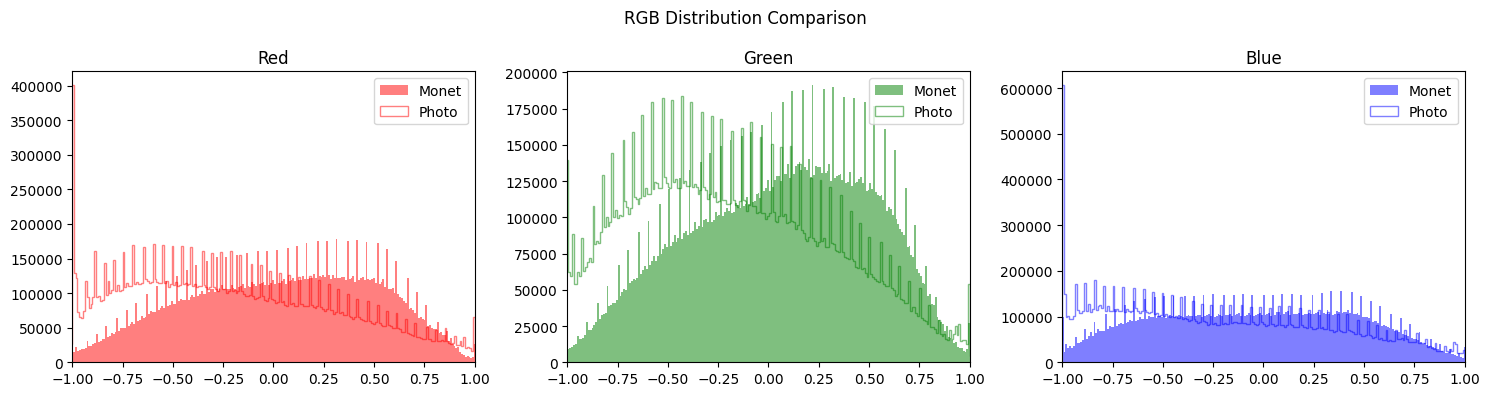

In [4]:
import numpy as np

plt.figure(figsize=(15, 4))
colors = ['r', 'g', 'b']

# Stack the list of tensors into a single numpy array
monet_stack = np.stack([img.numpy() for img in monet_ds], axis=0)
photo_stack = np.stack([img.numpy() for img in photo_ds], axis=0)

for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.hist(monet_stack[..., i].flatten(), bins=256, color=color, alpha=0.5, label="Monet")
    plt.hist(photo_stack[..., i].flatten(), bins=256, color=color, alpha=0.5, label="Photo", histtype='step')
    plt.title(['Red', 'Green', 'Blue'][i])
    plt.xlim([-1, 1])
    plt.legend()
plt.suptitle("RGB Distribution Comparison")
plt.tight_layout()
plt.show()

Lastly, I will mention that Monet pictures are not as detailed as real photos. They seem to be more blurred. It's not related to the quality of an image but is more about the actual style of the painter. This is an important factor that can affect the performance. I will explain this point in the next section and will address it while tuning the model.

### 4. Model Architectue
#### Comparison and architecture choice
While choosing the right architecture for this project I've made some research about different GAN types and their suitability for the task of style transfer. Below is the comparison summary:
* DCGAN, SGAN, EBGAN, and DRAGAN - Those architectures not directly suitable for the task, so I will ignore them.
* Pix2pix (Conditional GAN) - This is a simple and strong architecture for style transfer, but it works with paired dataset. Since in my case I do not have pairs for Monet pictures, this option will not work for me.
* StyleGAN - This architecture can work for style transfer, but it requires some adaptation.
* CycleGAN - This option is most suitable for style transfer and works with unpaired datasets.

Considering this comparison, I decided to choose the CycleGAN architecture for this project, as it seems most suitable for style-transfer with unpaired datasets. It is also quite popular and has many examples on the web, like the tutorial from TensorFlow: https://www.tensorflow.org/tutorials/generative/cyclegan. 

I will base my implementation on TensorFlow tutorial (which follows the U-architecture from the original paper). However, I will need to adapt it to my case. My main concern with CycleGAN is that the first Generator model is trained to preserve original content of the images, since they need to be transformed back to their originals (with the second Generator). The cycle-loss function makes sure to optimize the model for this behaviour. In my case this is not really necessary. I don't need the generated images to be similar to their originals. Instead, the goal is to make them monet-styled as much as possible, even if they lose original details. In case of Monet pictures this loss is expected, given the blurry and smooth texture of the style. To address that, I had to tune the model.

#### Hyperparameters tuning
Considering the above reasoning, I tuned the hyperparameters of the loss functions. I've set the loss weight of generator and discriminator equal to 1, while the weight for cycle-loss and identity-loss equal to 0.1. These weights were chosen after a few trial runs. I only included the final weights in the notebook.

Another adaptation I've made is the number of layers. TensorFlow tutorial proposes 8 convolutional layers in both upsample and downsample parts of the Generator. This is not necessary in my case, since the training dataset is very small (300 images). The augmented images help to increase the variety, but the do not defer much from the originals. Therefore, I reduced the number of layers by half.

I left some of the hyperparameters unchanged, as they appear in CycleGAN implementation by TensorFlow. The kernel size for convolutional layer is set to 4 in the tutorial. I tried to reduce it to 3, but it didn't work well. Apparently, style learnings need a wider kernel. For the same reason I'll keep the strides number as 2.

In the Results section I will describe the process of hyperparameters tuning in more details.

In the following cells I will build the CycleGAN model, which already includes the final hyperparameters:

In [5]:
# ====== CycleGAN Loss Functions ======
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(generated):
    return 1 * loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 0.1 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.1 * loss

In [6]:
# ====== CycleGAN Training Loop ======
@tf.function
def train_step(real_x, real_y, G, F, DX, DY,
               g_optimizer, f_optimizer, dx_optimizer, dy_optimizer):

    with tf.GradientTape(persistent=True) as tape:
        # Generate images
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)

        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator outputs
        disc_real_x = DX(real_x, training=True)
        disc_real_y = DY(real_y, training=True)

        disc_fake_x = DX(fake_x, training=True)
        disc_fake_y = DY(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    grads_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    grads_f = tape.gradient(total_gen_f_loss, F.trainable_variables)

    grads_dx = tape.gradient(disc_x_loss, DX.trainable_variables)
    grads_dy = tape.gradient(disc_y_loss, DY.trainable_variables)

    # Apply gradients
    g_optimizer.apply_gradients(zip(grads_g, G.trainable_variables))
    f_optimizer.apply_gradients(zip(grads_f, F.trainable_variables))
    dx_optimizer.apply_gradients(zip(grads_dx, DX.trainable_variables))
    dy_optimizer.apply_gradients(zip(grads_dy, DY.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss
    }

In [7]:
# ====== Model Builders ======
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=not apply_batchnorm))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)

    zero_pad1 = layers.ZeroPadding2D()(down2)
    conv = layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)


In [8]:
# ====== Training Loop Function ======
def train(G, F, DX, DY, monet_ds, photo_ds,
          g_optimizer, f_optimizer, dx_optimizer, dy_optimizer,
          epochs=10, checkpoint_dir="./checkpoints"):

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(G=G, F=F, DX=DX, DY=DY,
                                     g_optimizer=g_optimizer, f_optimizer=f_optimizer,
                                     dx_optimizer=dx_optimizer, dy_optimizer=dy_optimizer)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        step = 0
        for real_monet, real_photo in tf.data.Dataset.zip((monet_ds, photo_ds)):
            losses = train_step(real_photo, real_monet, G, F, DX, DY,
                                g_optimizer, f_optimizer, dx_optimizer, dy_optimizer)

            if step % 100 == 0:
                print(f"Step {step}: "
                      f"G_loss={losses['gen_g_loss']:.4f}, "
                      f"F_loss={losses['gen_f_loss']:.4f}, "
                      f"DX_loss={losses['disc_x_loss']:.4f}, "
                      f"DY_loss={losses['disc_y_loss']:.4f}")
            step += 1

        # Save checkpoint
        #manager.save()
        #print(f"Checkpoint saved at {manager.latest_checkpoint}")

In [9]:
# ====== Instantiate Models and Optimizers ======
G = Generator()  # Photo to Monet
F = Generator()  # Monet to Photo
DX = Discriminator()  # Discriminator for Photo
DY = Discriminator()  # Discriminator for Monet

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# ====== Start Training ======
train(G, F, DX, DY, monet_ds, photo_ds,
      g_optimizer, f_optimizer, dx_optimizer, dy_optimizer,
      epochs=10, checkpoint_dir="checkpoints")



Epoch 1/10


E0000 00:00:1748743622.069733      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_15_5/sequential_12_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748743623.484240      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


Step 0: G_loss=0.7809, F_loss=1.0056, DX_loss=1.5262, DY_loss=1.5323
Step 100: G_loss=0.7945, F_loss=0.7798, DX_loss=1.3998, DY_loss=1.4098
Step 200: G_loss=0.7663, F_loss=0.7861, DX_loss=1.4008, DY_loss=1.3957

Epoch 2/10
Step 0: G_loss=0.7585, F_loss=0.7117, DX_loss=1.4107, DY_loss=1.4467
Step 100: G_loss=0.7138, F_loss=0.7463, DX_loss=1.3896, DY_loss=1.3788
Step 200: G_loss=0.8192, F_loss=0.7442, DX_loss=1.3997, DY_loss=1.4021

Epoch 3/10
Step 0: G_loss=0.7799, F_loss=0.7095, DX_loss=1.4225, DY_loss=1.4007
Step 100: G_loss=0.7430, F_loss=0.7267, DX_loss=1.3914, DY_loss=1.3928
Step 200: G_loss=0.7525, F_loss=0.7634, DX_loss=1.3890, DY_loss=1.3862

Epoch 4/10
Step 0: G_loss=0.7796, F_loss=0.7327, DX_loss=1.4167, DY_loss=1.3977
Step 100: G_loss=0.7117, F_loss=0.7061, DX_loss=1.3863, DY_loss=1.3749
Step 200: G_loss=0.8012, F_loss=0.6972, DX_loss=1.3805, DY_loss=1.3940

Epoch 5/10
Step 0: G_loss=0.7289, F_loss=0.7804, DX_loss=1.3652, DY_loss=1.3603
Step 100: G_loss=0.7227, F_loss=0.7492,

### 5. Results and Analysis
After training the models, I can check the results. It's important to note, that the 4 loss values in the training process are not a good indicator of model performance. A model with a better (lower) loss can produc much worse images. The MiFID score is not correlated with loss values of the training.

In my testing I considered the visual appearance, as an initial evaluation of the performance. Here are the monet-styled images produced by my model:

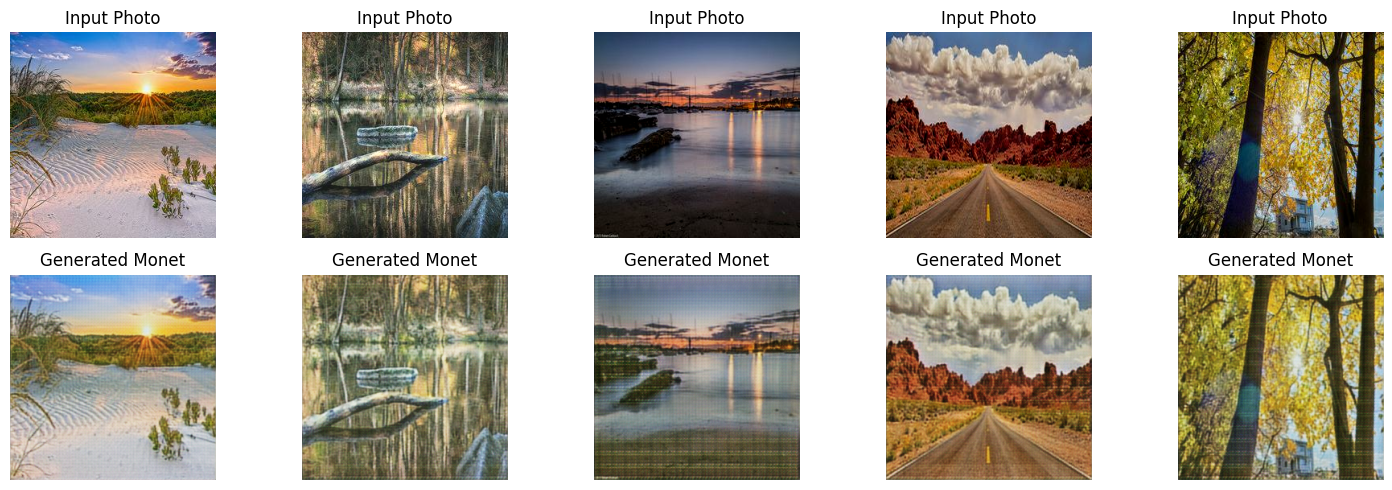

In [10]:
import numpy as np

def generate_and_plot_images(model, test_dataset, num_images):
    plt.figure(figsize=(15, 5))
    for i, photo in enumerate(test_dataset.take(num_images)):
        prediction = model(photo, training=False)[0].numpy()
        photo_img = (photo[0].numpy() + 1.0) / 2.0  # de-normalize
        prediction = (prediction + 1.0) / 2.0       # de-normalize

        plt.subplot(2, num_images, i + 1)
        plt.imshow(photo_img)
        plt.title("Input Photo")
        plt.axis("off")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(prediction)
        plt.title("Generated Monet")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

generate_and_plot_images(G, photo_ds, num_images=5)

The generated images are clearly resemble Monet style.

Next, I will submit the results, to see the MiFID score of my model:

In [11]:
import zipfile

output_dir = "/kaggle/working/"
zip_path = os.path.join(output_dir, "images.zip")
os.makedirs(output_dir, exist_ok=True)

def save_generated_images(model, test_dataset, num_images):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        print(f"Saving generated images to {zip_path}")
        
        # Generate and save images
        for i, photo in enumerate(test_dataset.take(num_images)):
            prediction = model(photo, training=False)[0].numpy()
            prediction = ((prediction + 1.0) * 127.5).astype(np.uint8)  # [0, 255]
            img_path = os.path.join(output_dir, f"monet_{i+1}.jpg")
            plt.imsave(img_path, prediction)
            # add image to zip
            zipf.write(img_path, os.path.basename(img_path))
            os.remove(img_path)
            if i % 100 == 0:
                print(f"Saved {i} images")

photo_ds = load_dataset(photo_dir).shuffle(7039).batch(1)

save_generated_images(G, photo_ds, num_images=7039)

Saving generated images to /kaggle/working/images.zip
Saved 0 images
Saved 100 images
Saved 200 images
Saved 300 images
Saved 400 images
Saved 500 images
Saved 600 images
Saved 700 images
Saved 800 images
Saved 900 images
Saved 1000 images
Saved 1100 images
Saved 1200 images
Saved 1300 images
Saved 1400 images
Saved 1500 images
Saved 1600 images
Saved 1700 images
Saved 1800 images
Saved 1900 images
Saved 2000 images
Saved 2100 images
Saved 2200 images
Saved 2300 images
Saved 2400 images
Saved 2500 images
Saved 2600 images
Saved 2700 images
Saved 2800 images
Saved 2900 images
Saved 3000 images
Saved 3100 images
Saved 3200 images
Saved 3300 images
Saved 3400 images
Saved 3500 images
Saved 3600 images
Saved 3700 images
Saved 3800 images
Saved 3900 images
Saved 4000 images
Saved 4100 images
Saved 4200 images
Saved 4300 images
Saved 4400 images
Saved 4500 images
Saved 4600 images
Saved 4700 images
Saved 4800 images
Saved 4900 images
Saved 5000 images
Saved 5100 images
Saved 5200 images
Save

The The MiFID score for the model is **69.7**

#### Hyperparameter optimization procedure (and what didn't work well)
The tuning of hyperparameters was particularly challenging in this project. As I already mentioned, one of the reasons for that is the lack of an accurate evaluation. I had to examine the results visualy after each small tweak of the parameters, and often had to submit the notebook to competition, just to see the score. This process is very time consuming. There is also a limit of 5 submissions per day.

Another issue was the unpredictable behaviour of the model for small changes. Increasing a Generator loss function weight by 10% could lead to completely currupted images. Dropout, BatchNormalization, LearningRate and others were all interdependent and hard to tune. The reason for that is the nature of CycleGAN model. It acts like a game between Generator and Discriminator. If the discriminator becomes too strong, the generator fails to learn, and vice-versa. On each cycle both Generator and Discriminator change and affect each other, which leads to high sensitivity of the hyperparameters.

Data augmentation was problematic as well. I ended up with only two changes: brightness and horizontal flip. Many other common augmentation techniques damaged the performance (for example flipping the image vertically). This can be explained by the fact that the style of a painter combines many charachteristics including scale, orientation, colors, facture, brush strokes and etc. Augmenting can harm some of these features and lead to bad results.

My troubleshooting in all these cases was based on trial and failure, elaborating on the results, trying to understand why something failed and thinking about what to try next.

### 6. Conclusion
This was an interesting project for implementing CycleGANs and understanding how it can be used for style-transfer task. I explored different approaches and saw the challenges while training the CycleGAN.

The main takeway for me from this project is that working with CycleGAN is challenging and the models require much tuning. Hovewer, the results are nice and demonstrate the generative power of CycleGAN. My final model achieved MiFID score of 69.7.

I also saw the big difference in training times, while training the model on GPU provided by Kaggle, in contrast to running on local machine with CPU.

One of the ideas for future improvements would be to integrate an MiFID score calculation into the training. If I could see that score after each epoch, it would be very helpful and more meaningful than loss values. Another idea is to implement DiffAugment algorithm for data augmentation, which was discovered a few years ago and to my understanding works particularly well for style-transfer tasks with CycleGANs. It will solve the problem with a small dataset for training.